<a href="https://colab.research.google.com/github/luisam19/course_optimizacion/blob/main/Entrega2_LuisaMariaZapataSaldarriaga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='056938'> **Problema de optimización** </font> </font>

* Descripción corta del problema de optimización

El problema de optimización el cual abordará este trabajo se centra en seleccionar un conjunto óptimo de épocas de una señal de Electroencefalografía en estado de reposo, buscando maximizar el valor promedio de las métricas de calidad mientras se minimiza el número de épocas de baja calidad. Para ello, se deben tomar decisiones sobre qué épocas incluir en el conjunto seleccionado, considerando restricciones como el número mínimo de épocas buenas en una señal y un porcentaje mínimo de épocas a seleccionar. Además, se debe garantizar que las épocas seleccionadas sean contiguas. Este problema busca encontrar el equilibrio entre la calidad de las épocas seleccionadas y la eficiencia en la selección.

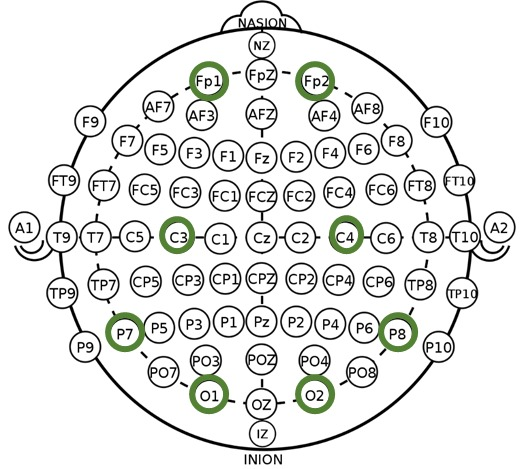

<font color='056938'> **Verbalización:**</font>

* **Para**:

* **decidir**:

* **Cumpliendo**:  




## <font color='056938'> **Conjuntos** </font>

- Conjunto de total de épocas: $E = \{1, 2, 3, \ldots, n\} $
- Conjunto de señales: $S = \{s_1, s_2, s_3\} $

## <font color='056938'> **Parámetros** </font>

- $n $: Número total de épocas
- $q_i$: Métrica de calidad de la época $i \in E $
- $p $: Porcentaje mínimo de épocas a seleccionar
- $y $: Número mínimo de épocas buenas en una señal (es una variable sobre la que haremos análisis de sensibilidad)

## <font color='056938'> **Variables de decisión** </font>

- $X_i $: Variable binaria que indica si se selecciona la época $i \in E $. $X_i = 1 $ si se selecciona, y $X_i = 0 $ de lo contrario.
- $U_i $: Variable de decisión que indica cuál es la última época seleccionada en una serie de épocas contiguas.
- $z $: Variable de decisión que minimiza el máximo de épocas dadas un umbral.

##  <font color='8EC044'> **Función Objetivo** </font>

$$
\text{Min} \quad z
$$

$$
\text{max} \sum_{i \in E} X_i
$$

## Sujeto a:

- Seleccionar épocas de buena señal según el umbral $z $:

$$
q_i X_i \leq z
$$

- Contigüidad de las épocas seleccionadas:

$$
X_i \leq X_{i+1} + U_i, \quad \forall i \in E \quad \text{excepto la última}
$$

$$
\sum_{i \in E} U_i = 1 \quad (\text{solo hay una última época})
$$

- Dominio de las variables de decisión:

$$
X_i \in \{0, 1\}, \quad U_i \in \{0, 1\}
$$

$$
z \geq 0
$$

- Porcentaje mínimo de épocas a seleccionar:

$$
\sum_{i \in E} X_i \geq p \cdot n
$$

- $p $ juega como un épsilon en la función multiobjetivo.


## <font color='8EC044'> **Instalación de librerias** </font>

In [48]:
!pip install mne==1.5.1

In [49]:
!pip install pyomo
!pip install highspy # Agregué un nuevo solver
!apt-get install -y -qq glpk-utils

In [50]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## <font color='8EC044'> **Carga de datos** </font>

In [66]:
path_data= '/content/drive/MyDrive/Colab Notebooks/Maestria/Tesis/epochs_review/sub-CTR001_ses-V0_task-CE_desc-wica_eeg.fif'
data=mne.io.read_raw(path_data)
data

Opening raw data file /content/drive/MyDrive/Colab Notebooks/Maestria/Tesis/epochs_review/sub-CTR001_ses-V0_task-CE_desc-wica_eeg.fif...
Isotrak not found
    Range : 0 ... 76249 =      0.000 ...   304.996 secs
Ready.


<Raw | sub-CTR001_ses-V0_task-CE_desc-wica_eeg.fif, 8 x 76250 (305.0 s), ~14 kB, data not loaded>

In [67]:
data.get_data().shape

(8, 76250)

In [68]:
# Crear eventos cada 5 segundos
events = mne.make_fixed_length_events(data, start=0, duration=5.0)


Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Loading data for 61 events and 1251 original time points ...
1 bad epochs dropped


<ipython-input-54-e88faf6a9b44>:3: FutureWarning: The current default events=None is deprecated and will change to events=True in MNE 1.6. Set events=False to suppress this warning.
  fig = epochs.plot()


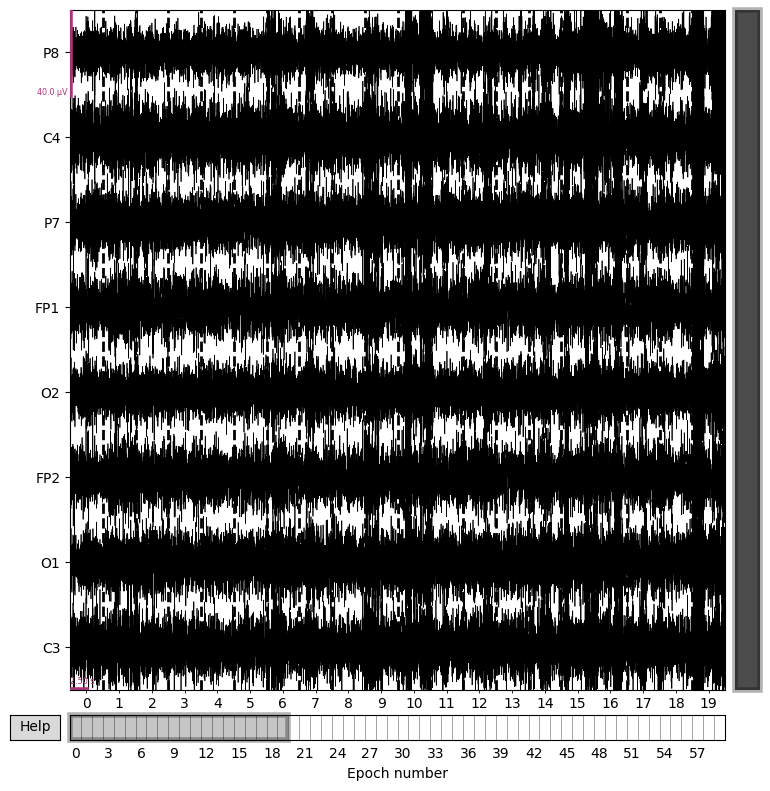

In [54]:
# Crear épocas de 5 segundos sin aplicar baseline
epochs = mne.Epochs(data, events, tmin=0, tmax=5, baseline=None, preload=True)
fig = epochs.plot()

In [55]:
epochs.get_data().shape

(60, 8, 1251)

In [56]:
# Definir los criterios de rechazo
reject_criteria = dict(eeg=100e-6)

# Inicializar una lista para almacenar los valores máximos por época y canal
epoch_metrics = []

# Iterar sobre las épocas para calcular las métricas de calidad
for epoch in epochs:
    epoch_max_values = epoch.max(axis=1)  # Valor máximo por canal en la época
    epoch_metrics.append(epoch_max_values)

# Convertir la lista a un array de numpy para facilidad de uso
import numpy as np
epoch_metrics = np.array(epoch_metrics)

# Aplicar el rechazo de épocas malas
epochs.drop_bad(reject=reject_criteria)

# Imprimir los valores de las métricas de calidad antes del rechazo
print("Valores de métricas de calidad antes del rechazo:")
for i, metrics in enumerate(epoch_metrics[:,0]):
    print(f"Época {i+1}: {metrics}")

# Mostrar cuáles épocas fueron eliminadas y por qué motivo
drop_log = epochs.drop_log
print("\nÉpocas eliminadas:")
for i, log in enumerate(drop_log):
    if log:  # Si la lista de razones no está vacía, la época fue eliminada
        print(f"Época {i+1} eliminada por: {log}")

# Identificar épocas eliminadas específicamente por el canal 1
channel_name = epochs.ch_names[0]  # Reemplazar por el nombre real del canal 1
epochs_rejected_by_channel_1 = []

for i, log in enumerate(drop_log):
    if log and any(channel_name in reason for reason in log):
        epochs_rejected_by_channel_1.append(i + 1)

print(f"\nÉpocas eliminadas específicamente por el {epochs.ch_names[0]}:")
print(epochs_rejected_by_channel_1)

    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8', 'C4', 'P7', 'O2', 'C3']
    Rejecting  epoch based on EEG : ['P8', 'C4']
    Rejecting  epoch based on EEG : ['P8', 'C4', 'P7', 'O2', 'C3']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8', 'C4', 'C3']
    Rejecting  epoch based on EEG : ['P8', 'C4', 'P7', 'FP1', 'O2', 'FP2', 'O1', 'C3']
    Rejecting  epoch based on EEG : ['P8', 'C4', 'P7', 'C3']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['P8', 'C4', 'P7', 'C3']
    Rejecting  epoch based on EEG : ['P8', 'C4', 'P7', 'C3']
    Rejecting  epoch based on EEG : ['P8', 'C4', 'C3']
    Rejecting  epoch based on EEG : ['P8', 'C3']
    Rejecting  epoch based on EEG : ['P8']
 

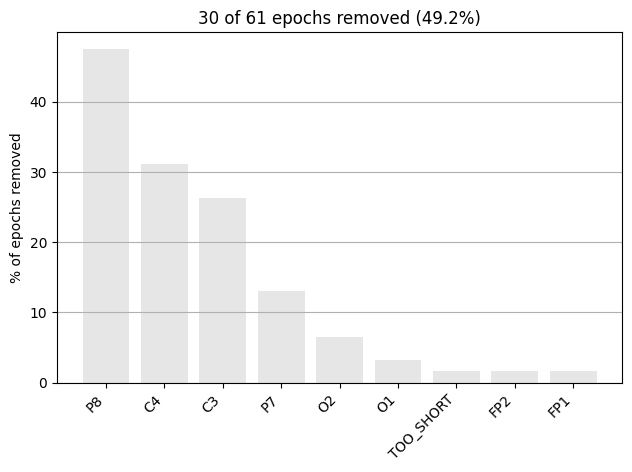

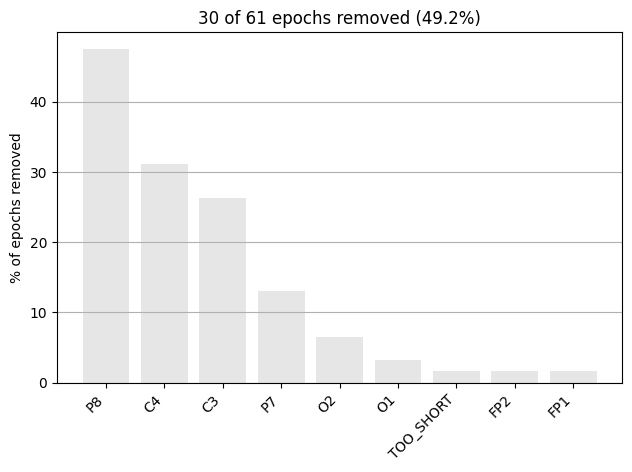

In [57]:
epochs.plot_drop_log()

In [58]:
# `epochs.drop_log` contiene una lista de tuplas. Vamos a transformar esta lista.
drop_log = epochs.drop_log

# Crear una lista de diccionarios para facilitar la creación del DataFrame
data = []
for idx, log in enumerate(drop_log):
    entry = {'Epoch': idx, 'Reason': log}
    data.append(entry)

# Crear el DataFrame
df = pd.DataFrame(data)

# Mostrar las estadísticas de rechazo
reasons = df['Reason'].apply(lambda x: ', '.join(x) if x else 'No Rejection')
reason_counts = reasons.value_counts()

print(reason_counts)


Reason
No Rejection                        31
P8                                   9
P8, C4, C3                           7
P8, C4                               4
P8, C4, P7, C3                       4
P8, C4, P7, O2, C3                   2
P8, C4, P7, FP1, O2, FP2, O1, C3     1
P8, C3                               1
P8, C4, P7, O2, O1, C3               1
TOO_SHORT                            1
Name: count, dtype: int64


In [59]:
import pandas as pd

# `epochs.drop_log` contiene una lista de tuplas. Vamos a transformar esta lista.
drop_log = epochs.drop_log

# Crear una lista de diccionarios para facilitar la creación del DataFrame
data = []
for idx, log in enumerate(drop_log):
    entry = {'Epoch': idx}
    for channel in log:
        entry[channel] = 1  # Marcar el canal para rechazo
    data.append(entry)

# Crear el DataFrame y llenar los NaNs con 0 (no rechazo)
df = pd.DataFrame(data).fillna(0)

# Mostrar el DataFrame resultante
print(df)

    Epoch   P8   C4   P7   O2   C3  FP1  FP2   O1  TOO_SHORT
0       0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        0.0
1       1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        0.0
2       2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        0.0
3       3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        0.0
4       4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        0.0
..    ...  ...  ...  ...  ...  ...  ...  ...  ...        ...
56     56  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        0.0
57     57  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        0.0
58     58  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        0.0
59     59  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0        0.0
60     60  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        1.0

[61 rows x 10 columns]


In [60]:
df.sum()

Epoch        1830.0
P8             29.0
C4             19.0
P7              8.0
O2              4.0
C3             16.0
FP1             1.0
FP2             1.0
O1              2.0
TOO_SHORT       1.0
dtype: float64

## <font color='8EC044'> **Modelo** </font>

In [61]:
import pyomo.environ as pyo
import numpy as np
import matplotlib.pyplot as plt

n = len(epoch_metrics)  # Número total de épocas
epoch_metrics = epoch_metrics[:,0]  # Métrica de calidad de cada época (simulada)

p = 0.8  # Porcentaje mínimo de épocas a seleccionar
y = 5    # Número mínimo de épocas buenas (parámetro para análisis de sensibilidad)

# Crear el modelo Pyomo
model = pyo.ConcreteModel()

# Conjuntos
model.E = pyo.RangeSet(1, n)  # Conjunto de todas las épocas

# Parámetros
model.q = {i: epoch_metrics[i-1] for i in model.E}  # Métrica de calidad de cada época
model.n = n  # Número total de épocas
model.p = p  # Porcentaje mínimo de épocas a seleccionar
model.y = y  # Número mínimo de épocas buenas

# Variables de decisión
model.X = pyo.Var(model.E, domain=pyo.Binary)  # Si la época i está seleccionada
model.U = pyo.Var(model.E, domain=pyo.Binary)  # Si la época i es la última seleccionada
model.z = pyo.Var(domain=pyo.NonNegativeReals)  # Métrica de calidad mínima

# Parámetro para el peso de la función objetivo combinada
model.epsilon = pyo.Param(initialize=1.0, mutable=True)  # Definir epsilon como un parámetro mutable

# Función objetivo combinada para maximizar el número de épocas seleccionadas y minimizar la métrica de calidad mínima
def combined_objective_rule(model):
    return model.z + model.epsilon * (sum(model.X[i] for i in model.E) - model.n * model.p)

model.obj = pyo.Objective(rule=combined_objective_rule, sense=pyo.minimize)

# Restricciones

#1. Selección según umbral z
def quality_constraint_rule(model, i):
    return model.q[i] * model.X[i] <= model.z
model.quality_constraint = pyo.Constraint(model.E, rule=quality_constraint_rule)

#2. Contigüidad de las épocas seleccionadas
def continuity_constraint_rule(model, i):
    if i != model.n:
        return model.X[i] <= model.X[i+1] + model.U[i]
    else:
        return pyo.Constraint.Skip
model.continuity_constraint = pyo.Constraint(model.E, rule=continuity_constraint_rule)

#Definición de la última época seleccionada:
def last_epoch_constraint_rule(model):
    return sum(model.U[i] for i in model.E) == 1
model.last_epoch_constraint = pyo.Constraint(rule=last_epoch_constraint_rule)

#Porcentaje mínimo de épocas a seleccionar:
def min_epochs_constraint_rule(model):
    return sum(model.X[i] for i in model.E) >= model.p * model.n
model.min_epochs_constraint = pyo.Constraint(rule=min_epochs_constraint_rule)

# Resolver el modelo
solver = pyo.SolverFactory('glpk')  # Seleccionar el solver (ej. GLPK)
results = solver.solve(model)



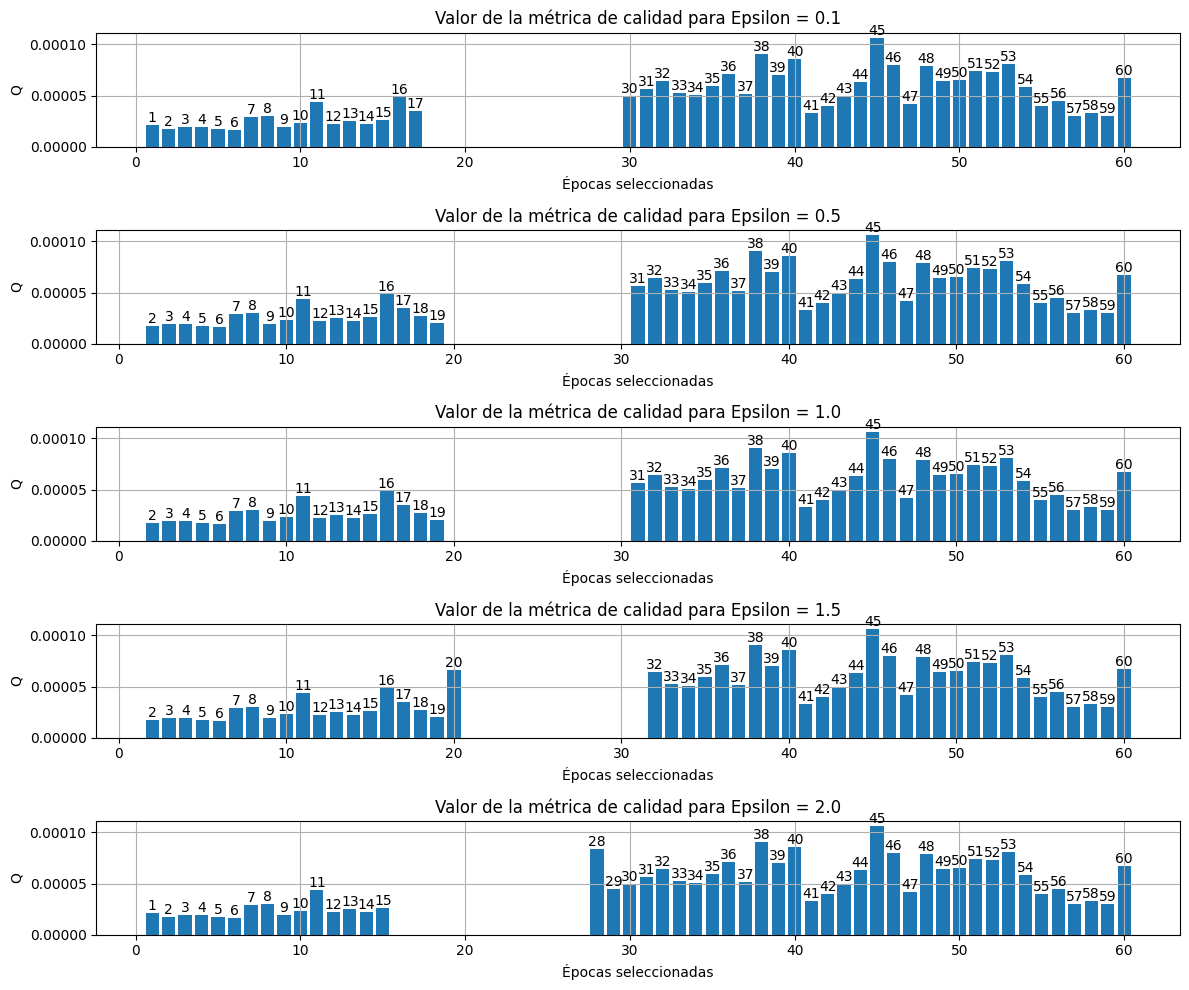

In [63]:
# Resolver el modelo para diferentes valores de epsilon y graficar los resultados
epsilon_values = [0.1, 0.5, 1.0, 1.5, 2.0]  # Valores de epsilon a probar
results = {}

solver = pyo.SolverFactory('glpk')  # Seleccionar el solver (ej. GLPK)

plt.figure(figsize=(12, 10))

for idx, epsilon in enumerate(epsilon_values):
    model.epsilon.set_value(epsilon)  # Establecer el valor de epsilon
    solver_results = solver.solve(model, tee=False)  # Resolver el modelo

    # Recopilar resultados
    selected_epochs = [i for i in model.E if pyo.value(model.X[i]) > 0]
    quality_values = [pyo.value(model.q[i]) for i in selected_epochs]

    # Graficar los resultados
    plt.subplot(len(epsilon_values), 1, idx + 1)
    bars = plt.bar(selected_epochs, quality_values)
    for bar, epoch in zip(bars, selected_epochs):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{epoch}', ha='center', va='bottom')

    plt.xlabel('Épocas seleccionadas')
    plt.ylabel('Q')
    plt.title(f'Valor de la métrica de calidad para Epsilon = {epsilon}')
    plt.grid(True)

plt.tight_layout()
plt.show()

La gráfica muestra el valor de la métrica de calidad $𝑞$ para diferentes épocas seleccionadas bajo varios valores de $𝜖$.

$$ϵ=0.1$$

La ponderación de la cantidad de épocas seleccionadas es baja. Por lo tanto, el modelo se enfoca más en minimizar $z$. Esto resulta en seleccionar menos épocas, típicamente aquellas con métricas de calidad más bajas, resultando en una gráfica con valores de q más bajos y menos variabilidad.

$$ϵ=0.5$$

Hay un equilibrio moderado entre minimizar $𝑧$ y maximizar la cantidad de épocas seleccionadas. Esto lleva a seleccionar más épocas con una mayor variabilidad en $q$.

$$ϵ=1.0,1.5,2.0$$

La ponderación para maximizar la cantidad de épocas seleccionadas aumenta. Aquí, el modelo selecciona más épocas para cumplir el porcentaje mínimo requerido, incluso si eso significa aceptar épocas con métricas de calidad más altas. Esto se refleja en una mayor variabilidad y dispersión en los valores de $q$ a través de las épocas seleccionadas.


Los resultados con este modelo, es una apróximación para poder seleccionar de forma óptima las épocas a trabajar, sin embargo, cabe aclarar que para los diferentes canales no se podría seleccionar las mismas épocas.